## Astrohack - Pytorch Example
<hr></hr>

#### Morphological stellar mass of a galaxy

The question we are interested in here is:<i>can we estimate the <i>M/L</i> using a single observation, at one wavelength?</i> Our dataset has images of the g-band (around 475 nm: blue). It is a supervised regression problem. Supervised, since the dataset actually has more observations and thus an accurate ground truth <i>M/L</i>. Regression, since the <i>M/L</i> is a continuous variable.
    
#### <u> Getting started:</u>
This notebook is should work with latest Pytorch 1.0,pandas,numpy. To run the notebooks, either jupyter notebook or jupyter lab is required. Care has to be taken to have the right CUDA toolkit version for Pytorch 1.0.

<ul>
    <li><a>1. Setup</a>
    <li><a>1.1 Download data:</a></li>
    <li><a>1.2 Install dependencies </a></li>
    <li><a>1.3 Import libraries </a></li>
    </li></ul>
<ul><li> <a>2. Prepare data </a>
     <li><a>2.1 Load metadata:</a></li>
    <li><a>2.2 split train and validation dataset</a></li>
    </li></ul>
<ul><li> <a>3. Define Convolution Neural Network </a></li>
       <li><a>3.1 Define loss function:</a></li>
    <li><a>3.2 Train network </a></li>
   </ul>
 <ul><li> <a>4. Evaluate the Network </a></li></ul>

## 1. Setup
### 1.1 Download data:
The AstroHack data files do not come along with this repository, you need to download them into the ./data directory before running this notebook.

### 1.2 Install dependencies
Run the following command to install dependencies

In [ ]:
!pip install -r requirement_pytorch.txt -q

### 1.3 Import libraries
Import necesseary libraries require to load, prepare our data and define our model.

In [1]:
import numpy as np
import pandas as pd
import os
import math

import PIL
from PIL import Image

import torch
from torch import *
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import random_split
import torch.nn as nn
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

import pycuda.driver as cuda
cuda.init()
torch.cuda.current_device()
cuda.Device(0).name()
torch.cuda.set_device(0) 

import matplotlib.pyplot as plt

##  2. Prepare data
 <p> We need to prepare data before we train our model.</p>
<p>Galaxies train,validation and evaluation dataset folder abosulute path is assignied to path variable and plotted before applying transformation and also plotted after applying transformation.</p>
<p> Dataset and dataLoader for train and test set is created.</p>

### 2.1 Load metadata.
Set path variable to train and evaluation directory to load images and metadata.

In [21]:
"""
Train_dir : An absolute path for train images.
Eval_dir  : An absolute path for evaluation images.
"""
Train_dir ="./data/train_images_128pix/"
Eval_dir = "./data/evaluation_images_128pix/"

In [24]:
train_dataframe = pd.read_csv(Train_dir+"train_metadata.tsv",sep='\t')
evaluation_dataframe = pd.read_csv(Eval_dir+"eval_metadata.tsv",sep='\t')

print("Train dataset shape: {} ".format(train_dataframe.shape))
print("Evaluation dataset shape: {} ".format(evaluation_dataframe.shape))

train_dataframe.head(5)

Train dataset shape: (51538, 6) 
Evaluation dataset shape: (22089, 5) 


,SDSS_ID,M/L,L_g,distance_Mpc,galsize_kpc,image_name
0,1237668271371976941,3.022229,1.205884e+10,189.000006,28.852800,1237668271371976941.png
1,1237661873478828168,2.057684,2.953450e+10,201.000002,36.891150,1237661873478828168.png
2,1237651495756234805,5.380972,1.078647e+10,180.428576,33.115510,1237651495756234805.png
3,1237661813339848849,1.525518,1.144418e+10,204.000005,27.124161,1237661813339848849.png
4,1237665532260450879,0.663993,5.546587e+09,208.285712,24.682299,1237665532260450879.png


Shown above are the top 3 rows in the training metadata files with columns:
<ul>
    <li>SDSS_ID: the unique identifier for each galaxy used by SDSS database.</li>
    <li>M/L: the ground truth Mass-to-Luminosity ratio.</li>
    <li>L_g: luminosity of the galaxy in g-band wavelength. Not used in this tutorial.</li>
    <li>distance_Mpc: the distance between the subject galaxy and Earth in megaparsec. Not used in this tutorial.</li> 
    <li>galsize_kpc: the size of the subject galaxy in kiloparsec. Not used in this tutorial.</li>
    <li>image_name: the filename of the corresponding image file.</li>
    </ul>
In this tutorial, we will use the image as the only feature to predict the M/L ratio.

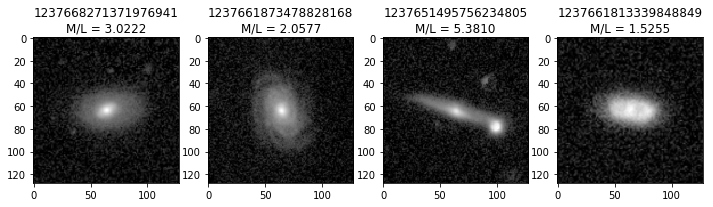

In [23]:
"""
Plot galaxy images before applying transformation.

"""

_show_n_images = 4
fig, axs = plt.subplots(ncols=_show_n_images, figsize=(3 * _show_n_images, 3))
for i in range(_show_n_images):
    axs[i].imshow(Image.open(os.path.join(Train_dir,train_dataframe['image_name'].iloc[i])), cmap='gray')
    axs[i].set_title('{}\nM/L = {:.4f}'.format(train_dataframe['SDSS_ID'].iloc[i], 
                                               train_dataframe['M/L'].iloc[i]))

In [5]:
""" Transform object is list of transformation that every images should get through it.
    - Image get flipped horizontally.
    - RGB image get converted to greyscale.
    - Weights in image get normalised.
"""
transform = transforms.Compose([transforms.RandomHorizontalFlip(), \
                                transforms.Grayscale(),\
                                transforms.ToTensor() ,\
                                transforms.Normalize((0.5,), (0.5,)) \
                               ])

In [6]:
""" A class to load images of galaxies,its corresponding metadata and apply transformation to preprocess the images.
    GimageLoad : A dataset class, which is defined to load images and its corresponding mass-to-light value as label.
    
    Parameters : 
        dataFile : A metadata file, which consists of image name to load,corresponding M/L value and it should present in rootdir.
        rootdir  : A path variable, path should have of images to load and metadata file.
        transform : List of transformation to apply on image.
        
    Return : Returns image and it corresponding mass-to-light value.
"""
class GimageLoad(torch.utils.data.Dataset):
    def __init__(self,dataFile,rootdir,transform=None):
        self.imageName = pd.read_csv(os.path.join(rootdir,dataFile),usecols=['image_name'],sep='\t')
        self.label =  pd.read_csv(os.path.join(rootdir,dataFile),usecols=['M/L'],sep='\t')
        self.root_dir = rootdir
        self.transform = transform
    def __len__(self):
        return len(self.imageName)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imageName.iloc[idx, 0])
        image = Image.open(img_name)
        
        image = self.transform(image)
        labels = self.label.iloc[idx, 0]

        return image,labels
    


### 2.2 Split train and validation dataset
To train and evaluate our model while model training, we have to split our dataset into train and validation set.

In [28]:
"""
A dataset and dataloader object is created for train,test images.
    
    train_size =  number of images split for training.
    test_size =  number of images split for validation.
    train_dataset = A torch dataset object.
    test_dataset = A torch dataset object.
    simageTrainLoader  : A dataloader object for train set.
    simageTestLoader   : A dataloader object for test set.
    
"""


smimage_load_train = GimageLoad("train_metadata.tsv", Train_dir,transform)

train_size = int(0.8 * len(smimage_load_train))
test_size = len(smimage_load_train) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(smimage_load_train, [train_size, test_size])

simageTrainLoader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=10)

simageTestLoader = torch.utils.data.DataLoader(test_dataset,batch_size=16,shuffle=True,num_workers=10)

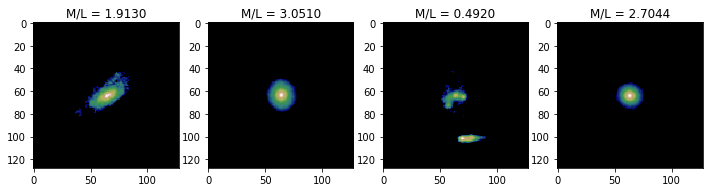

In [26]:
""" 
Plot images of galaxies transformed,scaled and processed through GimageLoad dataset and torch.utils dataloader.
"""
fig, axs = plt.subplots(ncols=_show_n_images, figsize=(3 * _show_n_images, 3))
for i,data in enumerate(torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=True)):
    if i == _show_n_images:
        break
    axs[i].imshow(Image.fromarray(np.uint8(plt.cm.gist_earth(data[0][0][0].numpy())*255)), cmap='gray')
    axs[i].set_title('M/L = {:.4f}'.format(data[1].numpy()[0]))

# 3. Define  Convolutional Neural Network

As input, a CNN takes tensors of shape (image_height, image_width, color_channels). since here images are greyscale, number of channel is 1. Instantiated model is moved to GPU.

In [16]:
""" CNN , A class to define convolution neural network model.

    Parameter : CNN class is inherits all properties from nn.Module in pytorch library.
    
    Return    : A CNN instatiated model.
"""


class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.5))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(0.5))

        self.fc1 = torch.nn.Linear(36992, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5))
        self.fc2 = torch.nn.Linear(625, 1, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# instantiate CNN model
simage_cnn = CNN()
simage_cnn.to(torch.device("cuda:0"))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=36992, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=36992, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=1, bias=True

### 3.1 Define a Loss function and optimizer
##### Loss function : SmoothL1Loss.
It uses a squared term if the absolute error falls below 1 and an absolute term otherwise. It is less sensitive to outliers than the mean square error loss and in some cases prevents exploding gradients. In mean square error loss, we square the difference which results in a number which is much larger than the original number. These high values result in exploding gradients. This is avoided here as for numbers greater than 1, the numbers are not squared.

In [17]:
""" L1LossFlat ,a class to define loss, 
    Paramater : inherits all properties and function of smoothl1loss.
    
    Return :  A loss value.

"""
class L1LossFlat(nn.SmoothL1Loss):
    def forward(self, in1:torch.Tensor, target:torch.Tensor):
        return super().forward(in1.view(-1), target.view(-1))

### 3.2 Train  network
 We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [18]:
import time

def trainNet(model, batch_size, n_epochs, learning_rate,checkpoint_path=os.getcwd()):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    min_val_loss = np.Inf
    epochs_no_improve = 0
    factor = 3 
    end_lr=1e-3
    
    model.train()
    #Get training data
    train_loader = simageTrainLoader
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss = L1LossFlat()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = model(inputs)

            loss_size = loss(outputs, labels.float())
            loss_size.backward()
        
            
            optimizer.step()

            running_loss += loss_size.data
            total_train_loss += loss_size.data
            
            #every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in simageTestLoader:
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = model(inputs)
            val_loss_size = loss(val_outputs, labels.float())
            total_val_loss += val_loss_size.data
    
        val_loss = total_val_loss / len(simageTestLoader)
        print(val_loss)
        if val_loss < min_val_loss:
              # Save the model
                torch.save(model, "checkpoint_path")
                epochs_no_improve = 0
                min_val_loss = val_loss
  
        else:
          epochs_no_improve += 1
          # Check early stopping condition
          if epochs_no_improve == n_epochs:
            print('Early stopping!')

            # Load in the best model
            model = torch.load(checkpoint_path)


        print("Epoch {}, \t train_loss: {:.2f}, \t Validation loss = {:.2f}".format(epoch+1,running_loss / print_every,total_val_loss / len(simageTestLoader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    
    return model

In [19]:
simage_cnn = CNN()
simage_cnn.to(torch.device("cuda:0"))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=36992, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=36992, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=1, bias=True

In [20]:
simage_cnn1 = trainNet(simage_cnn, batch_size=128, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 128
epochs= 10
learning_rate= 0.001
tensor(0.4215, device='cuda:0')


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1, 	 train_loss: 0.45, 	 Validation loss = 0.42
tensor(0.4335, device='cuda:0')
Epoch 2, 	 train_loss: 0.41, 	 Validation loss = 0.43
tensor(0.4160, device='cuda:0')
Epoch 3, 	 train_loss: 0.41, 	 Validation loss = 0.42
tensor(0.3982, device='cuda:0')
Epoch 4, 	 train_loss: 0.40, 	 Validation loss = 0.40
tensor(0.4009, device='cuda:0')
Epoch 5, 	 train_loss: 0.39, 	 Validation loss = 0.40
tensor(0.4053, device='cuda:0')
Epoch 6, 	 train_loss: 0.40, 	 Validation loss = 0.41
tensor(0.3889, device='cuda:0')
Epoch 7, 	 train_loss: 0.39, 	 Validation loss = 0.39
tensor(0.4099, device='cuda:0')
Epoch 8, 	 train_loss: 0.40, 	 Validation loss = 0.41
tensor(0.3983, device='cuda:0')
Epoch 9, 	 train_loss: 0.42, 	 Validation loss = 0.40
tensor(0.3941, device='cuda:0')
Epoch 10, 	 train_loss: 0.39, 	 Validation loss = 0.39
Training finished, took 1055.66s


## 4. Evaluate the network

In [26]:
smimage_load_test_pred = GimageLoad("eval_metadata2.tsv", Test_dir,transform)

simageTestLoader_test = torch.utils.data.DataLoader(smimage_load_test_pred,batch_size=1,shuffle=True)

torch.cuda.empty_cache()

val_pred_y = []
val_true_y = []
simage_cnn1.eval()
for inputs, labels in simageTestLoader_test:
            inputs = inputs.cuda()

            inputs = Variable(inputs.float())

            j = simage_cnn1(inputs)
            i_pred = float(j[0][0].cpu().detach().numpy())
            val_pred_y.append(i_pred)
            val_true_y.append(float(labels[0].numpy()))

In [40]:
torch.save(simage_cnn1,"smass_torch.pth")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


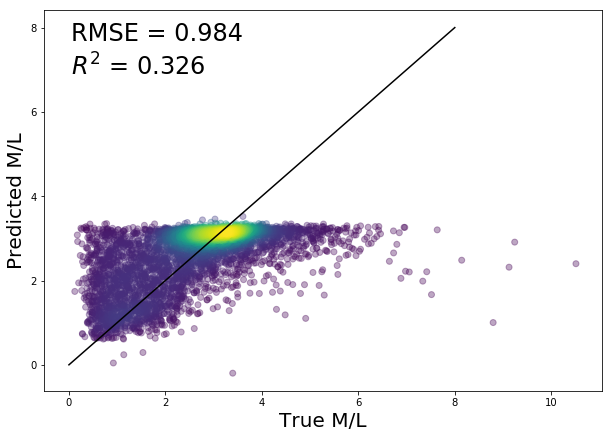

In [32]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = np.array(val_true_i)
    y_pred = np.array(val_pred_i)
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()